# Residential power usage classification into weekday, weekend, covid and vacation

Import the required libraries

In [52]:
import pandas as pd
import numpy as np 
import imblearn
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter

### Import data and do preliminary analysis

In [12]:
power_usage_df = pd.read_csv(r"C:\Users\808178\OneDrive - University of Witwatersrand\IBM Machine Learning Cert\Classification\Project for peer review\power_usage_2016_to_2020.csv", index_col = False)
print('Original number of records in tasks data: ', len(power_usage_df))
n = power_usage_df.shape[0]
p1 = pd.Series(range(n), pd.period_range('2016-06-01 00:00:00', freq = '1H', periods = n))
power_usage_df['StartDate'] = p1.to_frame().index
power_usage_df.head()

Original number of records in tasks data:  35952


,StartDate,Value (kWh),day_of_week,notes
0,2016-06-01 00:00,1.057,2,weekday
1,2016-06-01 01:00,1.171,2,weekday
2,2016-06-01 02:00,0.560,2,weekday
3,2016-06-01 03:00,0.828,2,weekday
4,2016-06-01 04:00,0.932,2,weekday


In [13]:
weather_report_df = pd.read_csv(r"C:\Users\808178\OneDrive - University of Witwatersrand\IBM Machine Learning Cert\Classification\Project for peer review\weather_2016_2020_daily.csv", index_col = False)
print('Original number of records in tasks data: ', len(weather_report_df))
m = weather_report_df.shape[0]
p2 = pd.Series(range(m), pd.period_range('2016-06-01', freq = '1D', periods = m))
weather_report_df['Date'] = p2.to_frame().index
weather_report_df.head()

Original number of records in tasks data:  1552


,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
0,2016-06-01,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
1,2016-06-02,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2,2016-06-03,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
3,2016-06-04,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
4,2016-06-05,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


Combine the two dataframes into one 

In [28]:
# Convert date columns to datetime
# Convert StartDate column to datetime, handling PeriodDtype if necessary
power_usage_df['StartDate'] = power_usage_df['StartDate'].apply(lambda x: x.to_timestamp() if hasattr(x, 'to_timestamp') else x)
power_usage_df['StartDate'] = pd.to_datetime(power_usage_df['StartDate'], format='%Y-%m-%d %H:%M', errors='coerce')
weather_report_df['Date'] = weather_report_df['Date'].apply(lambda x: x.to_timestamp() if hasattr(x, 'to_timestamp') else x)
weather_report_df['Date'] = pd.to_datetime(weather_report_df['Date'], format='%Y-%m-%d')

# Remove records from weather_report_df dated after '2020-07-07'
weather_report_df = weather_report_df[weather_report_df['Date'] < '2020-07-07']

# Add a new column in power_usage_df with the date only (without time)
power_usage_df['Date'] = power_usage_df['StartDate'].dt.date

# Group by the date column and calculate the sum of values for each day
power_usage_df_sum = power_usage_df.groupby(['Date', 'notes'], as_index=False)['Value (kWh)'].sum()
power_usage_df_sum.columns = ['Date','notes', 'Value_sum']  # Rename columns for clarity
# Reorder columns so that notes is at the end
power_usage_df_sum = power_usage_df_sum[['Date', 'Value_sum', 'notes']]

# Convert the date column back to datetime for merging
power_usage_df_sum['Date'] = pd.to_datetime(power_usage_df_sum['Date'])

# Merge weather_report_df, power_usage_df_sum on the date column
combined_df = pd.merge(weather_report_df, power_usage_df_sum, on='Date', how='left')
combined_df.head()


,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,...,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week,Value_sum,notes
0,2016-06-01,1,85,74.8,68,74,71.4,66,100,89.4,...,21,9.5,0,29.8,29.8,29.7,0.00,2,29.691,weekday
1,2016-06-02,2,76,71.2,66,74,70.3,66,100,96.8,...,18,7.8,0,29.8,29.8,29.7,4.33,5,28.789,weekend
2,2016-06-03,3,79,72.1,68,72,70.0,68,100,93.6,...,18,4.7,0,29.8,29.8,29.7,3.18,6,19.247,weekend
3,2016-06-04,4,76,71.2,69,73,70.0,66,100,96.1,...,20,7.0,0,29.8,29.7,29.7,2.37,2,22.883,weekday
4,2016-06-05,5,82,73.8,68,72,70.0,68,100,88.7,...,17,7.7,0,29.7,29.7,29.7,0.39,4,25.195,weekday


Check the distribution of classes

Text(0, 0.5, 'Frequency')

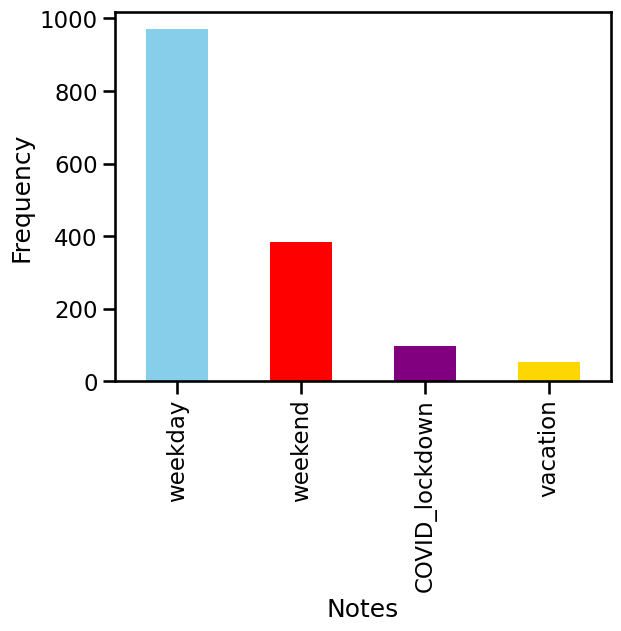

In [94]:
combined_df['notes'].value_counts()
# Visualize the count for each class
combined_df['notes'].value_counts().plot.bar(color=['skyblue', 'red', 'purple', 'gold'])
plt.xlabel('Notes')
plt.ylabel('Frequency')

### Feature transformation

In [30]:
combined_df.dtypes


Date           datetime64[ns]
Day                     int64
Temp_max                int64
Temp_avg              float64
Temp_min                int64
Dew_max                 int64
Dew_avg               float64
Dew_min                 int64
Hum_max                 int64
Hum_avg               float64
Hum_min                 int64
Wind_max                int64
Wind_avg              float64
Wind_min                int64
Press_max             float64
Press_avg             float64
Press_min             float64
Precipit              float64
day_of_week             int64
Value_sum             float64
notes                  object
dtype: object

In [31]:
combined_df.iloc[:, :-1].describe()

,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week,Value_sum
count,1503,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2018-06-19 07:04:25.868263680,15.658683,80.731204,71.226547,62.834331,66.214238,61.677445,56.441118,92.605456,74.474451,51.401863,15.901530,7.773054,1.394544,29.978110,29.907053,29.815502,0.159687,2.997339,21.302356
min,2016-06-01 00:00:00,1.000000,34.000000,27.600000,19.000000,18.000000,13.200000,10.000000,50.000000,31.500000,15.000000,6.000000,1.600000,0.000000,29.500000,28.800000,0.000000,0.000000,0.000000,0.280000
25%,2017-06-10 12:00:00,8.000000,73.000000,62.800000,52.000000,60.000000,53.400000,45.000000,90.000000,67.500000,41.000000,13.000000,5.700000,0.000000,29.900000,29.800000,29.700000,0.000000,1.000000,10.775500
50%,2018-06-19 00:00:00,16.000000,83.000000,73.700000,66.000000,70.000000,65.800000,62.000000,94.000000,75.200000,50.000000,15.000000,7.300000,0.000000,29.900000,29.900000,29.800000,0.000000,3.000000,16.780000
75%,2019-06-28 12:00:00,23.000000,91.000000,81.550000,75.000000,76.000000,73.100000,70.000000,100.000000,82.800000,61.000000,18.000000,9.500000,3.000000,30.100000,30.000000,29.900000,0.020000,5.000000,30.657000
max,2020-07-06 00:00:00,31.000000,101.000000,90.000000,83.000000,83.000000,79.800000,78.000000,100.000000,99.900000,97.000000,39.000000,23.900000,17.000000,30.600000,30.600000,30.500000,13.430000,6.000000,78.225300
std,NaN,8.823461,12.687250,12.470645,13.512034,12.368268,13.717538,15.259594,7.774323,11.848510,15.770476,4.847846,3.008519,2.518511,0.167836,0.162711,0.786059,0.667055,1.998333,12.676702


Text(0, 0.5, 'Frequency')

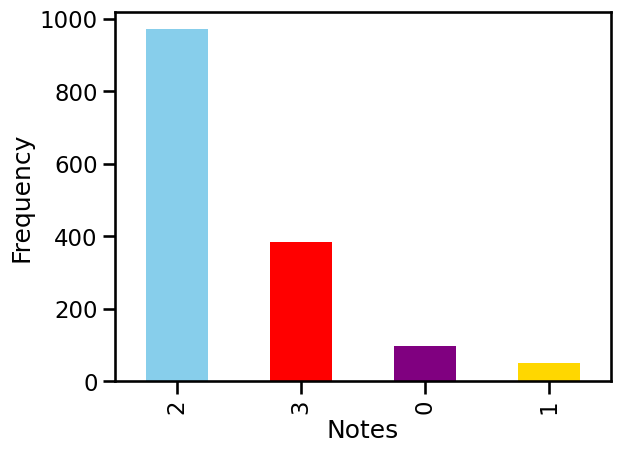

In [100]:
# Features exclude date, day and notes
features_ = combined_df.iloc[:, 2:-1]
target_ = combined_df.iloc[:, -1:]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scaling the input features
scaled_features = scaler.fit_transform(features_)

# Create a LabelEncoder object
label_encoder = LabelEncoder()
# Encode the target variable
encoded_target = label_encoder.fit_transform(target_.values.ravel())
np.unique(encoded_target, return_counts=True)

encoded_target_df = pd.Series(encoded_target)
# Visualize the count for each class
encoded_target_df.value_counts().plot.bar(color=['skyblue', 'red', 'purple', 'gold'])
plt.xlabel('Notes')
plt.ylabel('Frequency')

Prepare to train the logistic regression

In [101]:
# First, let's split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(scaled_features, encoded_target, test_size=0.2, stratify=encoded_target, random_state = 123)
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

# L1 penalty to shrink coefficients without removing any features from the model
penalty= 'l1'
# Our classification problem is multinomial
multi_class = 'multinomial'
# Use saga for L1 penalty and multinomial classes
solver = 'saga'
# Max iteration = 1000
max_iter = 1000

# Define a logistic regression model with above arguments
l1_model = LogisticRegression(random_state=123, penalty=penalty, multi_class=multi_class, solver=solver, max_iter=max_iter)
# Define a logistic regression model with above arguments

Training dataset shape, X_train: (1202, 18), y_train: (1202,)
Testing dataset shape, X_test: (301, 18), y_test: (301,)


Train the model

In [102]:
l1_model.fit(X_train, y_train)
l1_preds = l1_model.predict(X_test)

Evaluate the model

In [103]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [104]:
evaluate_metrics(y_test, l1_preds)

{'accuracy': 0.9003322259136213,
 'recall': array([0., 0., 1., 1.]),
 'precision': array([0.        , 0.        , 0.89814815, 0.90588235]),
 'f1score': array([0.        , 0.        , 0.94634146, 0.95061728])}

Confusion matrix

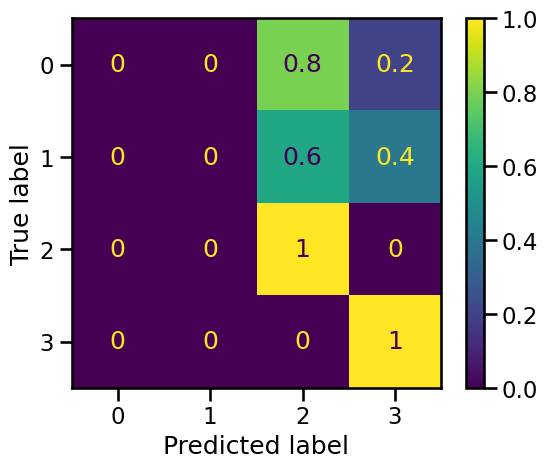

In [105]:
cf = confusion_matrix(y_test, l1_preds, normalize='true')
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=l1_model.classes_)
disp.plot()
plt.show()

### Balance the imbalanced classes using SMOTE

In [106]:
# Create a SMOTE sampler
smote_sampler = SMOTE(random_state = 123)
# Resample training data using SMOTE
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

Text(0, 0.5, 'Frequency')

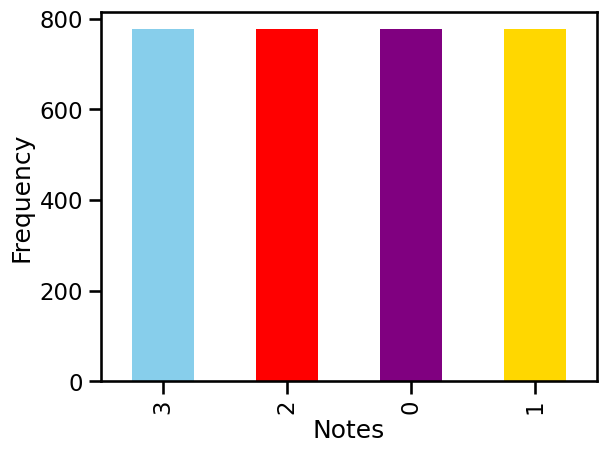

In [107]:
# Visualize classes
y_smo_series = pd.Series(y_smo)

# Plot the value counts as a bar chart
y_smo_series.value_counts().plot.bar(color=['skyblue', 'red', 'purple', 'gold'])
plt.xlabel('Notes')
plt.ylabel('Frequency')

### Explore different algorithms

Revisit logistic regression

In [108]:
# Re-train the model with resampled data
l1_model.fit(X_smo, y_smo)
l1_preds = l1_model.predict(X_test)

evaluate_metrics(y_test, l1_preds)

{'accuracy': 0.7109634551495017,
 'recall': array([0.55      , 0.5       , 0.68556701, 0.84415584]),
 'precision': array([0.21568627, 0.11904762, 0.96376812, 0.92857143]),
 'f1score': array([0.30985915, 0.19230769, 0.80120482, 0.88435374])}

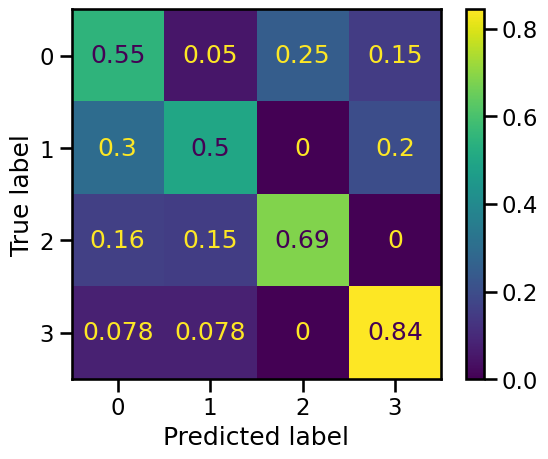

In [109]:
cf = confusion_matrix(y_test, l1_preds, normalize='true')
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=l1_model.classes_)
disp.plot()
plt.show()

Decision trees

In [110]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

dt_preds = dt.predict(X_test)

In [111]:
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred, average=None),
                      'recall': recall_score(y_true, y_pred, average=None),
                      'f1': f1_score(y_true, y_pred, average=None)},
                      name=label)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Print the series
print(measure_error(y_test, dt_preds, 'test'))


accuracy                                                               0.827243
precision    [0.08695652173913043, 0.3, 0.9132653061224489, 0.9027777777777778]
recall                       [0.1, 0.3, 0.9226804123711341, 0.8441558441558441]
f1              [0.09302325581395349, 0.3, 0.917948717948718, 0.87248322147651]
Name: test, dtype: object


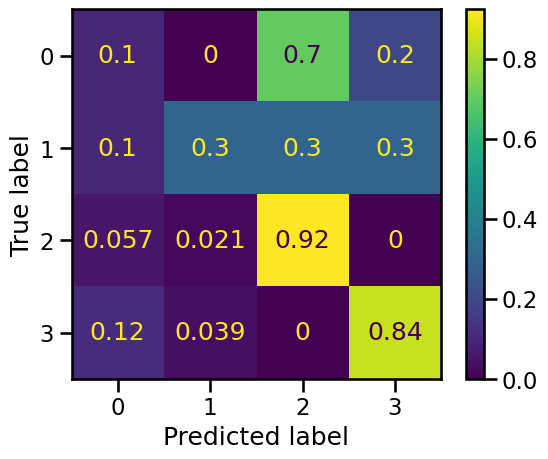

In [112]:
cf = confusion_matrix(y_test, dt_preds, normalize='true')
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=dt.classes_)
disp.plot()
plt.show()

Random forests

In [113]:
# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

Text(0, 0.5, 'OOB Error')

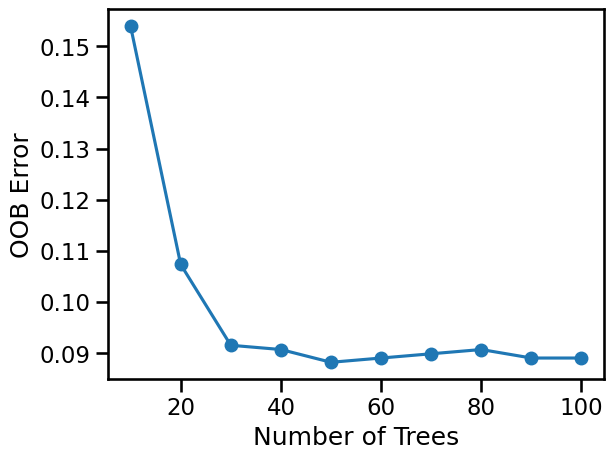

In [123]:
# Initialize the random forest estimator
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for number of trees
for n_trees in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it as a dictionary
    oob_list.append({'n_trees': n_trees, 'oob_error': oob_error})

# Convert the list of dictionaries to a DataFrame
rf_oob_df = pd.DataFrame(oob_list).set_index('n_trees')

rf_oob_df
# Plot OOB error against number of trees
plt.plot(rf_oob_df.index, rf_oob_df['oob_error'], marker='o', linestyle='-')


# Add labels to the x-axis and y-axis
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')

In [124]:
rf_preds = RF.predict(X_test)
measure_error(y_test, rf_preds, 'test')

accuracy                                                  0.913621
precision        [0.0, 1.0, 0.9065420560747663, 0.927710843373494]
recall                                        [0.0, 0.4, 1.0, 1.0]
f1           [0.0, 0.5714285714285715, 0.9509803921568627, 0.9625]
Name: test, dtype: object

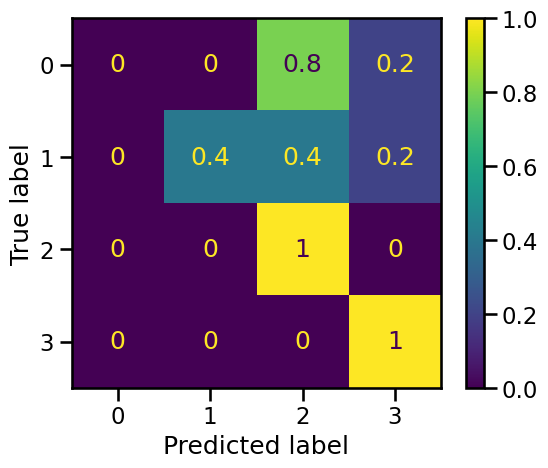

In [125]:
cf = confusion_matrix(y_test, rf_preds, normalize='true')
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=RF.classes_)
disp.plot()
plt.show()